In [72]:
import pandas as pd
dataset = pd.read_csv(r'C:\Users\mtsil\Desktop\german_essays.csv', encoding='unicode_escape')

In [73]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset.head(2)

,rater,thema,i_1,i_2,i_3,i_4,t_1,t_2,t_3,sr_1,sr_2,sr_3,sr_4,sa_1,sa_2,sa_3,sa_4,id_text,wle_dsch,sewle_dsch,punkte_dsch,sumscore,essay
0,9,1,2,2,1,1,0,2,1,2,1,2,2,2,2,1,2,K011_001,0.450426,0.551269,822.0,23,"Ich möchte gern in Spanien wohnen, am besten i..."
1,9,1,2,2,1,2,1,2,2,2,1,3,2,2,2,1,2,K011_002,1.651275,0.553108,916.0,27,Ich würde gerne in einem Haus leben. Es sollte...


In [74]:
# create df1 to store the essay variable

df1 = dataset['essay']

In [75]:
# add the values of the content criterion across each row; the sum score is stored in the df2 pandas data frame

pd.set_option('display.max_rows', None)
df2 = dataset[['i_1', 'i_2', 'i_3', 'i_4']].agg(['sum'], axis=1)
df2.head(2)

,sum
0,6
1,7


In [76]:
# concatenate df1 and df2 into a new pandas data frame called content
# the last three rows do not contain any values for the essay variable

content = pd.concat([df1, df2], axis=1)
content.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",6
1,Ich würde gerne in einem Haus leben. Es sollte...,7


In [77]:
# drop the last three rows and create the final pandas data frame called final_content

final_content = content.drop([125, 126, 127])
final_content.shape

(125, 2)

In [78]:
# check the distribution of the values for the content criterion

final_content[['sum']].value_counts()

sum
6      41
7      39
8      21
5      18
4       3
3       2
2       1
Name: count, dtype: int64

In [79]:
from sklearn.preprocessing import KBinsDiscretizer

# Quantile Discretization

quantile_discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
final_content['sum'] = quantile_discretizer.fit_transform(final_content[['sum']])

final_content.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",1.0
1,Ich würde gerne in einem Haus leben. Es sollte...,1.0


In [80]:
final_content['sum'] = final_content['sum'].astype(int)
final_content.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",1
1,Ich würde gerne in einem Haus leben. Es sollte...,1


In [81]:
final_content['sum'].value_counts(ascending = True)

sum
0     24
1    101
Name: count, dtype: int64

In [85]:
X = final_content['essay']
y = final_content['sum']

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 6000)
X = td.fit_transform(X).toarray()

In [87]:
# no need for the parameter test_size becauseone-third of the data it is set aside as test data, known as the out-of-bag (oob) sample 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     random_state=0, 
                                                    shuffle=True)

In [88]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 2.4473684210526314, 1: 0.6283783783783784}

In [89]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, class_weight= class_weights, max_features = 'log2', min_samples_split = 3, min_samples_leaf = 10, random_state=42, n_jobs=-1)
model.fit(X_train,y_train)


RandomForestClassifier(class_weight={0: 2.4473684210526314,
                                     1: 0.6283783783783784},
                       max_features='log2', min_samples_leaf=10,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [90]:
predictions = model.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score

In [91]:
print(f'Training set accuracy: {model.score(X_train, y_train):.4f}')
print(f'Test set accuracy: {model.score(X_test, y_test):.4f}')

Training set accuracy: 0.7849
Test set accuracy: 0.6875


In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.22      0.40      0.29         5
           1       0.87      0.74      0.80        27

    accuracy                           0.69        32
   macro avg       0.55      0.57      0.54        32
weighted avg       0.77      0.69      0.72        32



In [93]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,predictions)

<Axes: >

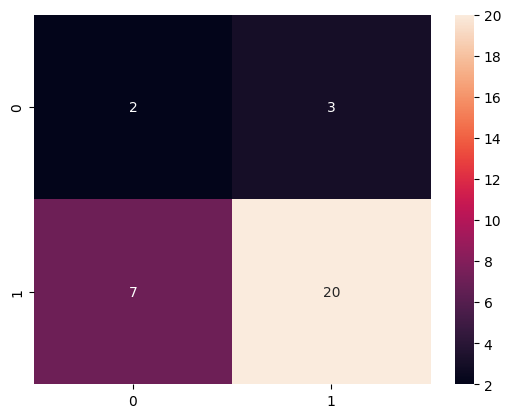

In [94]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='.2g')

In [95]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.6888888888888889

In [176]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, predictions)

0.22891566265060237

In [177]:
import joblib 


filename = 'joblib_model.sav'
joblib.dump(model, filename)

['joblib_model.sav']

In [178]:
loaded_model = joblib.load(filename)

In [179]:
loaded_model

RandomForestClassifier(class_weight={0: 1.1625, 1: 0.8773584905660378},
                       max_features='log2', min_samples_leaf=10,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [180]:
y_predict = model.predict(X_test)

In [181]:
print(classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

           0       0.40      0.67      0.50         9
           1       0.82      0.61      0.70        23

    accuracy                           0.62        32
   macro avg       0.61      0.64      0.60        32
weighted avg       0.70      0.62      0.64        32

